# 08. Aggregated PyOD - Multi-Level Analysis

Compare anomaly detection algorithms on **aggregated data** (Information Portraits):

**O(n²) algorithms** (only aggregated level):
- **KNN** - K-Nearest Neighbors (distance-based)
- **LOF** - Local Outlier Factor (density-based)
- **OCSVM** - One-Class SVM (boundary-based) - buyers only

**Fast algorithms** (both tender and aggregated levels):
- **IForest** - Isolation Forest
- **HBOS** - Histogram-based
- **ECOD** - Empirical CDF
- **COPOD** - Copula-based
- **AutoEncoder** - Neural network reconstruction
- **VAE** - Variational AutoEncoder

**Three levels of analysis:**
1. **Buyers** (36K) - all 9 algorithms
2. **Suppliers** (360K) - 8 algorithms (no OCSVM)
3. **Pairs** (500K) - 8 algorithms (no OCSVM)

In [1]:
import sys
sys.path.insert(0, '..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from src.data_loader import load_tenders, load_buyers, load_suppliers
from src.detectors import AggregatedPyOD

pd.set_option('display.max_columns', 50)
plt.style.use('seaborn-v0_8-whitegrid')

print(f"Started: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

Started: 2026-02-01 15:08:47


## 1. Load Data

In [2]:
# Load full dataset
tenders = load_tenders(years=[2022, 2023, 2024, 2025])
buyers = load_buyers()
suppliers = load_suppliers()

print(f"Tenders: {len(tenders):,}")
print(f"Buyers: {len(buyers):,}")
print(f"Suppliers: {len(suppliers):,}")

Scanning 2022...
Scanning 2023...
Scanning 2024...
Scanning 2025...
Loaded 12,877,960 records
Loaded buyers: 35,995
Loaded suppliers: 358,376
Tenders: 12,877,960
Buyers: 35,995
Suppliers: 358,376


## 2. Compare All Algorithms on Buyer Level

Running on 36K buyers instead of 13M tenders makes O(n²) algorithms feasible.

In [3]:
# All algorithms including slow ones (feasible on 36K buyers)
algorithms = ["iforest", "hbos", "ecod", "copod", "autoencoder", "vae", "knn", "ocsvm", "lof"]

results_dict = {}
comparison_data = []

for algo in algorithms:
    print()
    print("=" * 60)
    print(f"Algorithm: {algo.upper()}")
    print("=" * 60)
    
    start_time = datetime.now()
    
    detector = AggregatedPyOD(algorithm=algo, contamination=0.05)
    results = detector.detect_buyers(tenders, buyers)
    
    elapsed = (datetime.now() - start_time).total_seconds()
    
    anomalies = results[results['anomaly'] == 1]
    
    comparison_data.append({
        'algorithm': algo,
        'anomalies': len(anomalies),
        'anomaly_rate': len(anomalies) / len(results) * 100,
        'mean_score': results['score'].mean(),
        'max_score': results['score'].max(),
        'time_sec': elapsed,
    })
    
    results_dict[algo] = set(anomalies['buyer_id'].tolist())
    
    print(f"Time: {elapsed:.1f}s")
    print(f"Anomalies: {len(anomalies):,} ({len(anomalies)/len(results)*100:.2f}%)")


Algorithm: IFOREST
AggregatedPyOD (IFOREST): Detecting anomalous BUYERS...
  Using pre-computed buyer features
  Features: ['single_bidder_rate', 'competitive_rate', 'avg_discount_pct', 'supplier_diversity_index', 'total_tenders', 'avg_tender_value', 'total_value']
  Buyers: 35,995
  Anomalies: 1,800 (5.0%)
Time: 0.3s
Anomalies: 1,800 (5.00%)

Algorithm: HBOS
AggregatedPyOD (HBOS): Detecting anomalous BUYERS...
  Using pre-computed buyer features
  Features: ['single_bidder_rate', 'competitive_rate', 'avg_discount_pct', 'supplier_diversity_index', 'total_tenders', 'avg_tender_value', 'total_value']
  Buyers: 35,995
  Anomalies: 1,800 (5.0%)
Time: 1.7s
Anomalies: 1,800 (5.00%)

Algorithm: ECOD
AggregatedPyOD (ECOD): Detecting anomalous BUYERS...
  Using pre-computed buyer features
  Features: ['single_bidder_rate', 'competitive_rate', 'avg_discount_pct', 'supplier_diversity_index', 'total_tenders', 'avg_tender_value', 'total_value']
  Buyers: 35,995


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   2 out of   7 | elapsed:    1.5s remaining:    3.8s
[Parallel(n_jobs=7)]: Done   7 out of   7 | elapsed:    1.5s finished
[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   2 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=7)]: Done   7 out of   7 | elapsed:    0.0s finished


  Anomalies: 1,800 (5.0%)
Time: 1.6s
Anomalies: 1,800 (5.00%)

Algorithm: COPOD
AggregatedPyOD (COPOD): Detecting anomalous BUYERS...
  Using pre-computed buyer features
  Features: ['single_bidder_rate', 'competitive_rate', 'avg_discount_pct', 'supplier_diversity_index', 'total_tenders', 'avg_tender_value', 'total_value']
  Buyers: 35,995
  Anomalies: 1,800 (5.0%)
Time: 0.1s
Anomalies: 1,800 (5.00%)

Algorithm: AUTOENCODER
AggregatedPyOD (AUTOENCODER): Detecting anomalous BUYERS...
  Using pre-computed buyer features
  Features: ['single_bidder_rate', 'competitive_rate', 'avg_discount_pct', 'supplier_diversity_index', 'total_tenders', 'avg_tender_value', 'total_value']
  Buyers: 35,995
  Anomalies: 1,800 (5.0%)
Time: 72.4s
Anomalies: 1,800 (5.00%)

Algorithm: VAE
AggregatedPyOD (VAE): Detecting anomalous BUYERS...
  Using pre-computed buyer features
  Features: ['single_bidder_rate', 'competitive_rate', 'avg_discount_pct', 'supplier_diversity_index', 'total_tenders', 'avg_tender_value

In [4]:
# Comparison table
comparison_df = pd.DataFrame(comparison_data)
print()
print("=" * 60)
print("COMPARISON RESULTS (Buyer-Level)")
print("=" * 60)
display(comparison_df)


COMPARISON RESULTS (Buyer-Level)


,algorithm,anomalies,anomaly_rate,mean_score,max_score,time_sec
0,iforest,1800,5.000695,0.200051,1.0,0.269594
1,hbos,1800,5.000695,0.217950,1.0,1.691832
2,ecod,1800,5.000695,0.149125,1.0,1.599639
3,copod,1800,5.000695,0.158711,1.0,0.079682
4,autoencoder,1800,5.000695,0.034647,1.0,72.395106
5,vae,1800,5.000695,0.036102,1.0,45.116144
6,knn,1800,5.000695,0.002072,1.0,0.197405
7,ocsvm,1800,5.000695,0.328199,1.0,48.961112
8,lof,1800,5.000695,0.000245,1.0,0.251717


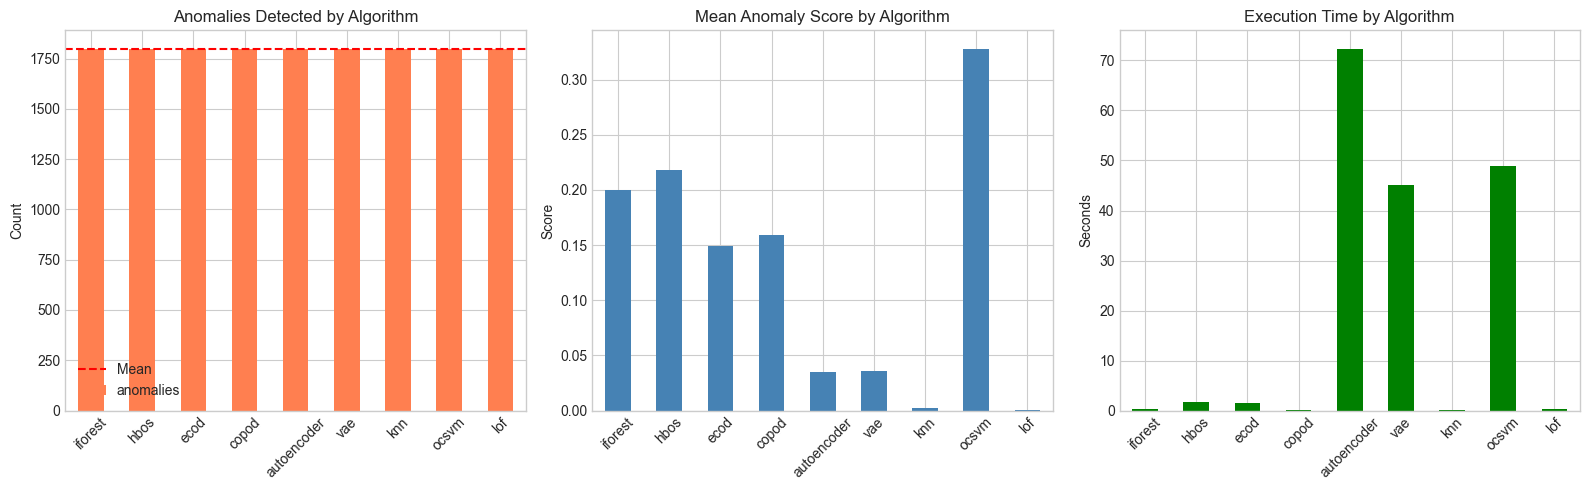

In [5]:
# Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Anomaly count
ax1 = axes[0]
comparison_df.plot(kind='bar', x='algorithm', y='anomalies', ax=ax1, color='coral', legend=False)
ax1.set_title('Anomalies Detected by Algorithm')
ax1.set_xlabel('')
ax1.set_ylabel('Count')
ax1.tick_params(axis='x', rotation=45)
ax1.axhline(y=comparison_df['anomalies'].mean(), color='red', linestyle='--', label='Mean')
ax1.legend()

# Mean score
ax2 = axes[1]
comparison_df.plot(kind='bar', x='algorithm', y='mean_score', ax=ax2, color='steelblue', legend=False)
ax2.set_title('Mean Anomaly Score by Algorithm')
ax2.set_xlabel('')
ax2.set_ylabel('Score')
ax2.tick_params(axis='x', rotation=45)

# Execution time
ax3 = axes[2]
comparison_df.plot(kind='bar', x='algorithm', y='time_sec', ax=ax3, color='green', legend=False)
ax3.set_title('Execution Time by Algorithm')
ax3.set_xlabel('')
ax3.set_ylabel('Seconds')
ax3.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('../results/aggregated_pyod_buyer_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

## 3. Algorithm Agreement Analysis

In [6]:
from itertools import combinations

print("Pairwise Agreement (Jaccard Similarity):")
print("=" * 60)

jaccard_matrix = pd.DataFrame(index=algorithms, columns=algorithms, dtype=float)

for algo1, algo2 in combinations(algorithms, 2):
    set1 = results_dict[algo1]
    set2 = results_dict[algo2]
    intersection = len(set1 & set2)
    union = len(set1 | set2)
    jaccard = intersection / union if union > 0 else 0
    
    jaccard_matrix.loc[algo1, algo2] = jaccard
    jaccard_matrix.loc[algo2, algo1] = jaccard
    
    print(f"{algo1:8} vs {algo2:8}: {jaccard:.3f} ({intersection:,} common)")

# Fill diagonal
for algo in algorithms:
    jaccard_matrix.loc[algo, algo] = 1.0

Pairwise Agreement (Jaccard Similarity):
iforest  vs hbos    : 0.353 (939 common)
iforest  vs ecod    : 0.623 (1,382 common)
iforest  vs copod   : 0.733 (1,523 common)
iforest  vs autoencoder: 0.732 (1,521 common)
iforest  vs vae     : 0.522 (1,235 common)
iforest  vs knn     : 0.564 (1,298 common)
iforest  vs ocsvm   : 0.610 (1,364 common)
iforest  vs lof     : 0.067 (226 common)
hbos     vs ecod    : 0.455 (1,125 common)
hbos     vs copod   : 0.367 (966 common)
hbos     vs autoencoder: 0.269 (763 common)
hbos     vs vae     : 0.207 (618 common)
hbos     vs knn     : 0.234 (683 common)
hbos     vs ocsvm   : 0.231 (675 common)
hbos     vs lof     : 0.058 (198 common)
ecod     vs copod   : 0.709 (1,494 common)
ecod     vs autoencoder: 0.500 (1,200 common)
ecod     vs vae     : 0.351 (936 common)
ecod     vs knn     : 0.462 (1,138 common)
ecod     vs ocsvm   : 0.465 (1,142 common)
ecod     vs lof     : 0.051 (174 common)
copod    vs autoencoder: 0.650 (1,418 common)
copod    vs vae     :

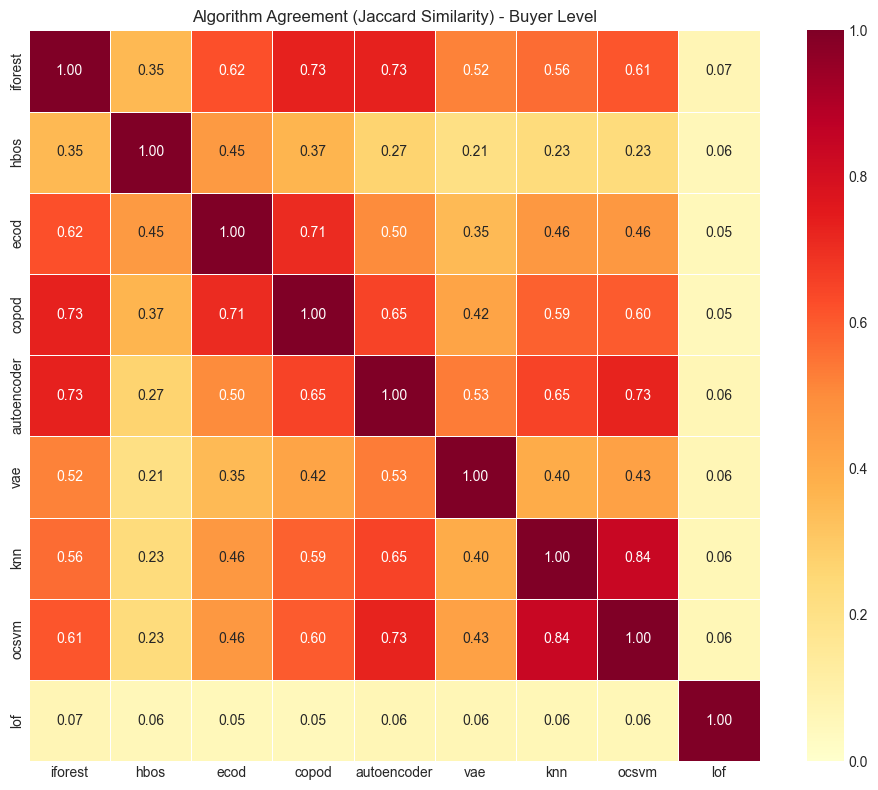

In [7]:
# Heatmap of algorithm agreement
plt.figure(figsize=(10, 8))
sns.heatmap(jaccard_matrix.astype(float), annot=True, fmt='.2f', cmap='YlOrRd', 
            square=True, linewidths=0.5, vmin=0, vmax=1)
plt.title('Algorithm Agreement (Jaccard Similarity) - Buyer Level')
plt.tight_layout()
plt.savefig('../results/aggregated_pyod_agreement_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

## 4. Consensus Analysis

In [8]:
from collections import Counter

# Count how many algorithms flagged each buyer
all_flagged = []
for algo, buyer_ids in results_dict.items():
    all_flagged.extend(buyer_ids)

flag_counts = Counter(all_flagged)

# Consensus levels
consensus_levels = {}
for threshold in range(1, len(algorithms) + 1):
    count = len([b for b, c in flag_counts.items() if c >= threshold])
    consensus_levels[f">={threshold} algorithms"] = count

print("Consensus Analysis:")
print("=" * 40)
for level, count in consensus_levels.items():
    print(f"{level}: {count:,} buyers")

Consensus Analysis:
>=1 algorithms: 5,220 buyers
>=2 algorithms: 2,701 buyers
>=3 algorithms: 2,152 buyers
>=4 algorithms: 1,817 buyers
>=5 algorithms: 1,480 buyers
>=6 algorithms: 1,261 buyers
>=7 algorithms: 995 buyers
>=8 algorithms: 535 buyers
>=9 algorithms: 39 buyers


In [9]:
# High-consensus anomalies (flagged by 5+ algorithms)
high_consensus_buyers = [b for b, c in flag_counts.items() if c >= 5]

print(f"High-consensus anomalies (5+ algorithms): {len(high_consensus_buyers):,} buyers")

if high_consensus_buyers:
    # Merge with buyer details
    high_consensus_df = buyers[buyers['buyer_id'].isin(high_consensus_buyers)].copy()
    high_consensus_df['algorithms_flagged'] = high_consensus_df['buyer_id'].map(flag_counts)
    high_consensus_df = high_consensus_df.sort_values('algorithms_flagged', ascending=False)
    
    print(f"\nTotal tender value: {high_consensus_df['total_value'].sum()/1e9:.2f} B UAH")
    print(f"Mean single_bidder_rate: {high_consensus_df['single_bidder_rate'].mean()*100:.1f}%")
    
    print("\nTop 10 by consensus:")
    display(high_consensus_df.head(10)[['buyer_id', 'buyer_name', 'algorithms_flagged', 
                                         'total_tenders', 'total_value', 'single_bidder_rate']])

High-consensus anomalies (5+ algorithms): 1,480 buyers

Total tender value: 1773.82 B UAH
Mean single_bidder_rate: 32.7%

Top 10 by consensus:


,buyer_id,buyer_name,algorithms_flagged,total_tenders,total_value,single_bidder_rate
957,37485401,УПРАВЛІННЯ ЖИТЛОВО-КОМУНАЛЬНОГО ГОСПОДАРСТВА Т...,9,2085,7.416207e+08,0.470149
26283,42764567,"КОМУНАЛЬНА УСТАНОВА ""АГЕНТСТВО РОЗВИТКУ ГРОМАД...",9,29,1.903928e+06,0.428571
3698,32835966,"КОМУНАЛЬНЕ ПІДПРИЄМСТВО ""ЦЕНТРАЛІЗОВАНА ЗАКУПІ...",9,957,1.343858e+09,0.705729
32123,26639202,Військова частина А4959,9,4,2.620000e+05,0.250000
22898,36816884,"Комунальне підприємство""Комбінат дитячого харч...",9,56,6.436444e+08,0.708333
3744,36094821,"КОМУНАЛЬНЕ ПІДПРИЄМСТВО ""ІНФО-РАДА-ДНІПРО"" ДНІ...",9,947,1.155477e+09,0.488152
29573,26643445,Військова частина А5172,9,12,2.045481e+07,0.916667
29369,14312453,"ДЕРЖАВНЕ ПІДПРИЄМСТВО ЗАВОД ""ГЕНЕРАТОР""",9,13,6.039438e+06,1.000000
19050,35527690,"КОМУНАЛЬНИЙ ЗАКЛАД ""ПАВЛОГРАДСЬКА ШКОЛА МИСТЕЦ...",9,104,7.052830e+06,0.250000
27879,26615070,Військова частина А2892,9,20,1.168313e+07,0.125000


## 5. LOF vs Global Algorithms

LOF (Local Outlier Factor) detects **local anomalies** - entities that are unusual compared to their neighbors.
IForest and others detect **global anomalies** - entities unusual compared to the entire dataset.

In [10]:
# LOF-only anomalies (local but not global)
lof_set = results_dict['lof']
iforest_set = results_dict['iforest']

lof_only = lof_set - iforest_set
iforest_only = iforest_set - lof_set
both = lof_set & iforest_set

print("LOF vs IForest Comparison:")
print("=" * 40)
print(f"LOF only (local anomalies):     {len(lof_only):,}")
print(f"IForest only (global anomalies): {len(iforest_only):,}")
print(f"Both (local + global):           {len(both):,}")

LOF vs IForest Comparison:
LOF only (local anomalies):     1,574
IForest only (global anomalies): 1,574
Both (local + global):           226


In [11]:
# Analyze LOF-only anomalies
if lof_only:
    lof_only_df = buyers[buyers['buyer_id'].isin(lof_only)].copy()
    
    print("LOF-only anomalies (unusual in local context but not globally extreme):")
    print(f"  Count: {len(lof_only_df):,}")
    print(f"  Mean single_bidder_rate: {lof_only_df['single_bidder_rate'].mean()*100:.1f}%")
    print(f"  Mean total_tenders: {lof_only_df['total_tenders'].mean():.0f}")
    print(f"  Total value: {lof_only_df['total_value'].sum()/1e9:.2f} B UAH")

LOF-only anomalies (unusual in local context but not globally extreme):
  Count: 1,574
  Mean single_bidder_rate: 1.8%
  Mean total_tenders: 395
  Total value: 263.03 B UAH


## 7. Supplier-Level Analysis (360K)

Running on suppliers - skip OCSVM (too slow for 360K records).

In [12]:
# Supplier-level: skip OCSVM (O(n²) too slow for 360K)
supplier_algorithms = ["iforest", "hbos", "ecod", "copod", "autoencoder", "vae", "knn", "lof"]

supplier_results_dict = {}
supplier_comparison_data = []

for algo in supplier_algorithms:
    print()
    print("=" * 60)
    print(f"Algorithm: {algo.upper()} (Suppliers)")
    print("=" * 60)
    
    start_time = datetime.now()
    
    detector = AggregatedPyOD(algorithm=algo, contamination=0.05)
    results = detector.detect_suppliers(tenders)
    
    elapsed = (datetime.now() - start_time).total_seconds()
    
    anomalies = results[results['anomaly'] == 1]
    
    supplier_comparison_data.append({
        'algorithm': algo,
        'anomalies': len(anomalies),
        'anomaly_rate': len(anomalies) / len(results) * 100,
        'mean_score': results['score'].mean(),
        'time_sec': elapsed,
    })
    
    supplier_results_dict[algo] = set(anomalies['supplier_id'].tolist())
    
    print(f"Time: {elapsed:.1f}s")
    print(f"Anomalies: {len(anomalies):,} ({len(anomalies)/len(results)*100:.2f}%)")


Algorithm: IFOREST (Suppliers)
AggregatedPyOD (IFOREST): Detecting anomalous SUPPLIERS...
  Computing supplier features from tenders...
  Features: ['total_awards', 'total_value', 'avg_award_value', 'buyer_count', 'single_bidder_rate', 'avg_competitors']
  Suppliers: 358,377
  Anomalies: 17,919 (5.0%)
Time: 10.9s
Anomalies: 17,919 (5.00%)

Algorithm: HBOS (Suppliers)
AggregatedPyOD (HBOS): Detecting anomalous SUPPLIERS...
  Computing supplier features from tenders...
  Features: ['total_awards', 'total_value', 'avg_award_value', 'buyer_count', 'single_bidder_rate', 'avg_competitors']
  Suppliers: 358,377
  Anomalies: 17,719 (4.9%)
Time: 8.2s
Anomalies: 17,719 (4.94%)

Algorithm: ECOD (Suppliers)
AggregatedPyOD (ECOD): Detecting anomalous SUPPLIERS...
  Computing supplier features from tenders...
  Features: ['total_awards', 'total_value', 'avg_award_value', 'buyer_count', 'single_bidder_rate', 'avg_competitors']
  Suppliers: 358,377


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   6 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed:    0.1s finished


  Anomalies: 17,914 (5.0%)
Time: 8.8s
Anomalies: 17,914 (5.00%)

Algorithm: COPOD (Suppliers)
AggregatedPyOD (COPOD): Detecting anomalous SUPPLIERS...
  Computing supplier features from tenders...
  Features: ['total_awards', 'total_value', 'avg_award_value', 'buyer_count', 'single_bidder_rate', 'avg_competitors']
  Suppliers: 358,377


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed:    0.0s finished


  Anomalies: 17,919 (5.0%)
Time: 8.3s
Anomalies: 17,919 (5.00%)

Algorithm: AUTOENCODER (Suppliers)
AggregatedPyOD (AUTOENCODER): Detecting anomalous SUPPLIERS...
  Computing supplier features from tenders...
  Features: ['total_awards', 'total_value', 'avg_award_value', 'buyer_count', 'single_bidder_rate', 'avg_competitors']
  Suppliers: 358,377
  Anomalies: 17,919 (5.0%)
Time: 741.2s
Anomalies: 17,919 (5.00%)

Algorithm: VAE (Suppliers)
AggregatedPyOD (VAE): Detecting anomalous SUPPLIERS...
  Computing supplier features from tenders...
  Features: ['total_awards', 'total_value', 'avg_award_value', 'buyer_count', 'single_bidder_rate', 'avg_competitors']
  Suppliers: 358,377
  Anomalies: 17,878 (5.0%)
Time: 453.8s
Anomalies: 17,878 (4.99%)

Algorithm: KNN (Suppliers)
AggregatedPyOD (KNN): Detecting anomalous SUPPLIERS...
  Computing supplier features from tenders...
  Features: ['total_awards', 'total_value', 'avg_award_value', 'buyer_count', 'single_bidder_rate', 'avg_competitors']
  

In [13]:
# Supplier comparison table
supplier_comparison_df = pd.DataFrame(supplier_comparison_data)
print()
print("=" * 60)
print("COMPARISON RESULTS (Supplier-Level)")
print("=" * 60)
display(supplier_comparison_df)

# Supplier consensus
supplier_all_flagged = []
for algo, ids in supplier_results_dict.items():
    supplier_all_flagged.extend(ids)

supplier_flag_counts = Counter(supplier_all_flagged)

print()
print("Supplier Consensus:")
print("=" * 40)
for threshold in range(1, len(supplier_algorithms) + 1):
    count = len([s for s, c in supplier_flag_counts.items() if c >= threshold])
    print(f">={threshold} algorithms: {count:,} suppliers")


COMPARISON RESULTS (Supplier-Level)


,algorithm,anomalies,anomaly_rate,mean_score,time_sec
0,iforest,17919,5.000042,0.151341,10.916358
1,hbos,17719,4.944235,0.152051,8.208513
2,ecod,17914,4.998647,0.101742,8.847752
3,copod,17919,5.000042,0.085170,8.279588
4,autoencoder,17919,5.000042,0.050714,741.216201
5,vae,17878,4.988601,0.035185,453.823778
6,knn,17919,5.000042,0.006158,8.656868
7,lof,17916,4.999205,0.000495,8.882068



Supplier Consensus:
>=1 algorithms: 54,078 suppliers
>=2 algorithms: 26,543 suppliers
>=3 algorithms: 22,257 suppliers
>=4 algorithms: 15,456 suppliers
>=5 algorithms: 11,662 suppliers
>=6 algorithms: 8,111 suppliers
>=7 algorithms: 4,977 suppliers
>=8 algorithms: 19 suppliers


## 8. Pair-Level Analysis (Buyer-Supplier Relationships)

Detect anomalous buyer-supplier pairs with 3+ contracts.

In [14]:
# Pair-level: skip OCSVM (O(n²) too slow for 500K+ pairs)
pair_algorithms = ["iforest", "hbos", "ecod", "copod", "autoencoder", "vae", "knn", "lof"]

pair_results_dict = {}
pair_comparison_data = []

for algo in pair_algorithms:
    print()
    print("=" * 60)
    print(f"Algorithm: {algo.upper()} (Pairs)")
    print("=" * 60)
    
    start_time = datetime.now()
    
    detector = AggregatedPyOD(algorithm=algo, contamination=0.05)
    results = detector.detect_pairs(tenders, min_contracts=3)
    
    elapsed = (datetime.now() - start_time).total_seconds()
    
    if len(results) > 0:
        anomalies = results[results['anomaly'] == 1]
        
        pair_comparison_data.append({
            'algorithm': algo,
            'total_pairs': len(results),
            'anomalies': len(anomalies),
            'anomaly_rate': len(anomalies) / len(results) * 100,
            'mean_score': results['score'].mean(),
            'time_sec': elapsed,
        })
        
        # Store as tuple set for consensus
        pair_results_dict[algo] = set(
            zip(anomalies['buyer_id'].tolist(), anomalies['supplier_id'].tolist())
        )
        
        print(f"Time: {elapsed:.1f}s")
        print(f"Anomalies: {len(anomalies):,} ({len(anomalies)/len(results)*100:.2f}%)")


Algorithm: IFOREST (Pairs)
AggregatedPyOD (IFOREST): Detecting anomalous PAIRS...
  Computing pair features from tenders...
  Pairs with 3+ contracts: 916,278
  Features: ['contracts_count', 'total_value', 'avg_value', 'single_bidder_rate', 'exclusivity_buyer', 'exclusivity_supplier']
  Anomalies: 45,814 (5.0%)
Time: 11.1s
Anomalies: 45,814 (5.00%)

Algorithm: HBOS (Pairs)
AggregatedPyOD (HBOS): Detecting anomalous PAIRS...
  Computing pair features from tenders...
  Pairs with 3+ contracts: 916,278
  Features: ['contracts_count', 'total_value', 'avg_value', 'single_bidder_rate', 'exclusivity_buyer', 'exclusivity_supplier']
  Anomalies: 45,801 (5.0%)
Time: 6.7s
Anomalies: 45,801 (5.00%)

Algorithm: ECOD (Pairs)
AggregatedPyOD (ECOD): Detecting anomalous PAIRS...
  Computing pair features from tenders...
  Pairs with 3+ contracts: 916,278
  Features: ['contracts_count', 'total_value', 'avg_value', 'single_bidder_rate', 'exclusivity_buyer', 'exclusivity_supplier']


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   6 | elapsed:    1.3s remaining:    2.7s
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed:    1.4s finished


  Anomalies: 45,814 (5.0%)
Time: 8.4s
Anomalies: 45,814 (5.00%)

Algorithm: COPOD (Pairs)
AggregatedPyOD (COPOD): Detecting anomalous PAIRS...
  Computing pair features from tenders...
  Pairs with 3+ contracts: 916,278
  Features: ['contracts_count', 'total_value', 'avg_value', 'single_bidder_rate', 'exclusivity_buyer', 'exclusivity_supplier']


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   6 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed:    0.1s finished


  Anomalies: 45,814 (5.0%)
Time: 7.5s
Anomalies: 45,814 (5.00%)

Algorithm: AUTOENCODER (Pairs)
AggregatedPyOD (AUTOENCODER): Detecting anomalous PAIRS...
  Computing pair features from tenders...
  Pairs with 3+ contracts: 916,278
  Features: ['contracts_count', 'total_value', 'avg_value', 'single_bidder_rate', 'exclusivity_buyer', 'exclusivity_supplier']
  Anomalies: 45,814 (5.0%)
Time: 1847.2s
Anomalies: 45,814 (5.00%)

Algorithm: VAE (Pairs)
AggregatedPyOD (VAE): Detecting anomalous PAIRS...
  Computing pair features from tenders...
  Pairs with 3+ contracts: 916,278
  Features: ['contracts_count', 'total_value', 'avg_value', 'single_bidder_rate', 'exclusivity_buyer', 'exclusivity_supplier']
  Anomalies: 45,814 (5.0%)
Time: 1108.2s
Anomalies: 45,814 (5.00%)

Algorithm: KNN (Pairs)
AggregatedPyOD (KNN): Detecting anomalous PAIRS...
  Computing pair features from tenders...
  Pairs with 3+ contracts: 916,278
  Features: ['contracts_count', 'total_value', 'avg_value', 'single_bidder_r

In [15]:
# Pair comparison table
pair_comparison_df = pd.DataFrame(pair_comparison_data)
print()
print("=" * 60)
print("COMPARISON RESULTS (Pair-Level)")
print("=" * 60)
display(pair_comparison_df)

# Pair consensus
if pair_results_dict:
    pair_all_flagged = []
    for algo, pairs in pair_results_dict.items():
        pair_all_flagged.extend(pairs)
    
    pair_flag_counts = Counter(pair_all_flagged)
    
    print()
    print("Pair Consensus:")
    print("=" * 40)
    for threshold in range(1, len(pair_algorithms) + 1):
        count = len([p for p, c in pair_flag_counts.items() if c >= threshold])
        print(f">={threshold} algorithms: {count:,} pairs")


COMPARISON RESULTS (Pair-Level)


,algorithm,total_pairs,anomalies,anomaly_rate,mean_score,time_sec
0,iforest,916278,45814,5.000011,0.188926,11.077213
1,hbos,916278,45801,4.998592,0.169217,6.732044
2,ecod,916278,45814,5.000011,0.153717,8.435383
3,copod,916278,45814,5.000011,0.108586,7.468778
4,autoencoder,916278,45814,5.000011,0.089153,1847.205122
5,vae,916278,45814,5.000011,0.074772,1108.226931
6,knn,916278,45814,5.000011,0.019612,14.100422
7,lof,916278,45814,5.000011,0.003609,17.024129



Pair Consensus:
>=1 algorithms: 138,229 pairs
>=2 algorithms: 75,248 pairs
>=3 algorithms: 51,942 pairs
>=4 algorithms: 38,936 pairs
>=5 algorithms: 29,066 pairs
>=6 algorithms: 21,611 pairs
>=7 algorithms: 8,937 pairs
>=8 algorithms: 2,530 pairs


## 9. Summary & Save Results

In [16]:
# Summary of all levels
print("=" * 60)
print("MULTI-LEVEL ANALYSIS SUMMARY")
print("=" * 60)

print("\n1. BUYER-LEVEL (36K):")
print(f"   Algorithms: {len(algorithms)} (including OCSVM)")
print(f"   High-consensus (5+): {len([b for b, c in flag_counts.items() if c >= 5]):,} buyers")

print("\n2. SUPPLIER-LEVEL (360K):")
print(f"   Algorithms: {len(supplier_algorithms)} (no OCSVM)")
print(f"   High-consensus (4+): {len([s for s, c in supplier_flag_counts.items() if c >= 4]):,} suppliers")

if pair_results_dict:
    print("\n3. PAIR-LEVEL:")
    print(f"   Algorithms: {len(pair_algorithms)} (no OCSVM)")
    print(f"   High-consensus (4+): {len([p for p, c in pair_flag_counts.items() if c >= 4]):,} pairs")

# Save all results
print()
print("Saving results...")

# Buyer results
comparison_df.to_csv('../results/aggregated_pyod_buyer_comparison.csv', index=False)
high_consensus_df.to_csv('../results/aggregated_pyod_high_consensus_buyers.csv', index=False)

# Supplier results
supplier_comparison_df.to_csv('../results/aggregated_pyod_supplier_comparison.csv', index=False)
high_consensus_suppliers = [s for s, c in supplier_flag_counts.items() if c >= 4]
pd.DataFrame({'supplier_id': high_consensus_suppliers}).to_csv(
    '../results/aggregated_pyod_high_consensus_suppliers.csv', index=False
)

# Pair results
if pair_comparison_data:
    pair_comparison_df.to_csv('../results/aggregated_pyod_pair_comparison.csv', index=False)
    high_consensus_pairs = [(b, s) for (b, s), c in pair_flag_counts.items() if c >= 4]
    pd.DataFrame(high_consensus_pairs, columns=['buyer_id', 'supplier_id']).to_csv(
        '../results/aggregated_pyod_high_consensus_pairs.csv', index=False
    )

print("Results saved to ../results/")
print(f"\nCompleted: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

MULTI-LEVEL ANALYSIS SUMMARY

1. BUYER-LEVEL (36K):
   Algorithms: 9 (including OCSVM)
   High-consensus (5+): 1,480 buyers

2. SUPPLIER-LEVEL (360K):
   Algorithms: 8 (no OCSVM)
   High-consensus (4+): 15,456 suppliers

3. PAIR-LEVEL:
   Algorithms: 8 (no OCSVM)
   High-consensus (4+): 38,936 pairs

Saving results...
Results saved to ../results/

Completed: 2026-02-01 16:23:04
